In [33]:
#########imports########

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from skimage import io
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [34]:
Train_DIR = r"C:\Codes\2019RGBnonwaterbodyCancelled"
Valid_DIR = r"C:\Codes\2019RGBnonwaterbodyCancelled\Valid"
Test_DIR = r"C:\Codes\2019RGBnonwaterbodyCancelled\Test"




In [35]:
x_train_dir = os.path.join(Train_DIR, 'Band')
y_train_dir = os.path.join(Train_DIR, 'Label')

x_valid_dir = os.path.join(Valid_DIR, 'Band')
y_valid_dir = os.path.join(Valid_DIR, 'Label')

#x_valid_dir = os.path.join(DATA_DIR, '2017_Band2_Cropped')
#y_valid_dir = os.path.join(DATA_DIR, '2017_Label_Cropped')

x_test_dir = os.path.join(Test_DIR, 'Band')
y_test_dir = os.path.join(Test_DIR, 'Label')
print(x_train_dir)

C:\Codes\2019RGBnonwaterbodyCancelled\Band


In [36]:

ids = os.listdir(x_train_dir)
images_fps = [os.path.join(x_train_dir, image_id) for image_id in ids]
print(len(images_fps))

80


In [37]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(12, 12))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
        #print(image)
        plt.savefig("img{}.jpg".format(n))
    plt.show()
    

In [38]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [39]:
class Dataset(BaseDataset):
    
    
    CLASSES = ['nonwaterbody','waterbody']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        print(self.class_values)
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image= io.imread(self.images_fps[i])
        #image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image.astype('uint8') * 255, cv2.COLOR_BGR2RGB)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = io.imread(self.masks_fps[i], 0)
        #print(image.shape)
        # extract certain classes from mask (e.g. cars)
#         mask[mask<128] = 0 # For diffused boudnaries
#         mask[mask>=128] = 1

        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = image, sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing( image=image,mask=mask)
            image, mask = sample['image'], sample['mask']
        #print(mask.shape) 
        return image, mask
        
    def __len__(self):
        
        return len(self.ids)


[1]


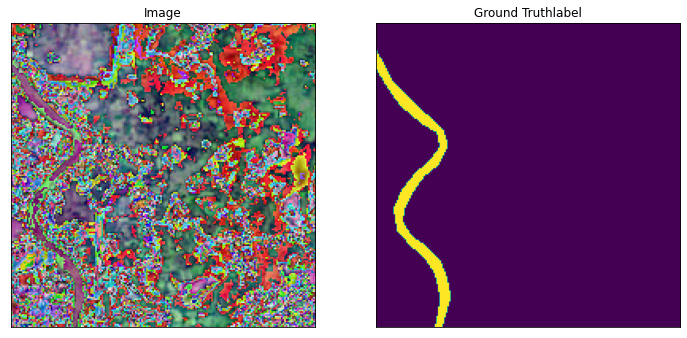

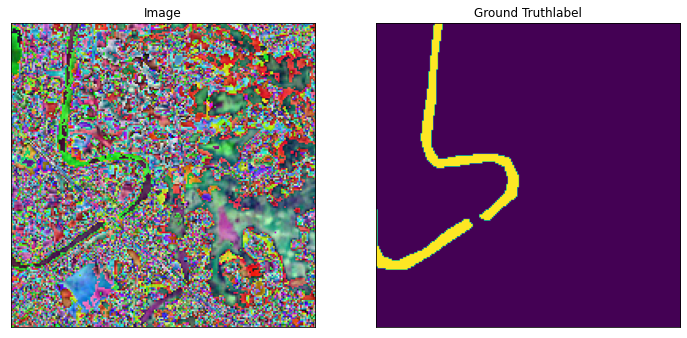

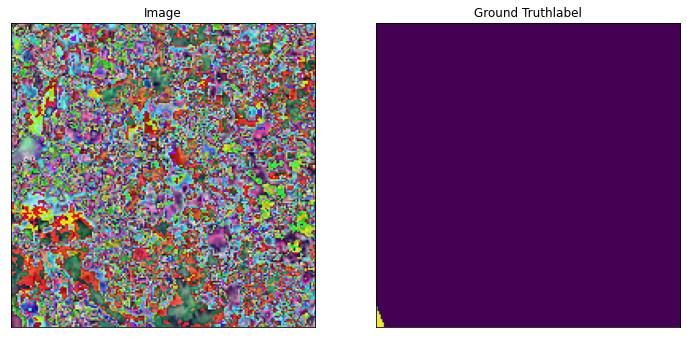

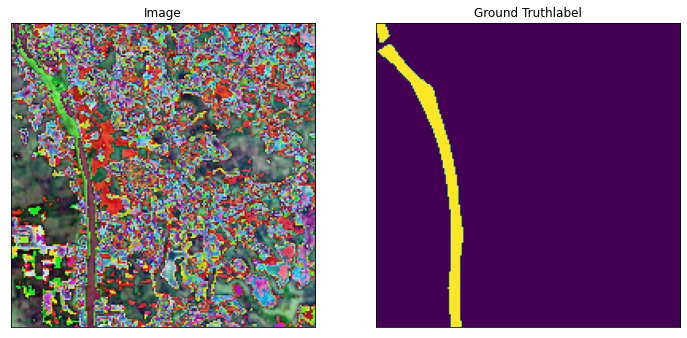

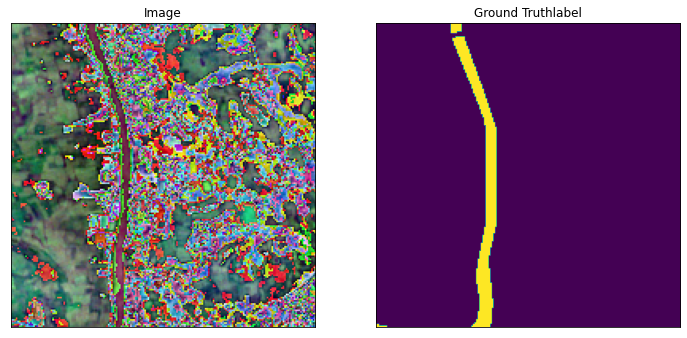

In [40]:
# dataset = Dataset(x_train_dir, y_train_dir, classes=['waterbody'])
# print(len(dataset))

# image, mask = dataset[250] # get some sample
# visualize(
#     image=image, 
#     cars_mask=mask.squeeze(),
# )

dataset = Dataset(x_train_dir, y_train_dir,classes=['waterbody'])
#print(len(dataset))

# image, mask = dataset[69] # get some sample
# visualize(
#     image=image, 
#     cars_mask=mask.squeeze(),
# )
# dataset

for i in range(5):
    num = 20+i
    image,mask = dataset[num]
    visualize(
        image = image,
        ground_truthlabel = mask.squeeze()
    )

In [41]:
import torch
import numpy as np
import segmentation_models_pytorch as smp


In [42]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['waterbody']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [45]:

import albumentations as albu
albumvalue=96
def get_training_augmentation():
    train_transform = [
        
#        albu.HorizontalFlip(p=0.5),

#         albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

#         albu.PadIfNeeded(min_height=albumvalue, min_width=albumvalue, always_apply=True, border_mode=0),
#         albu.RandomCrop(height=albumvalue, width=albumvalue, always_apply=True),

         albu.IAAAdditiveGaussianNoise(p=0.7),
#         albu.IAAPerspective(p=0.5),

#         albu.OneOf(
#             [
#                 albu.CLAHE(p=1),
#                 albu.RandomBrightness(p=1),
#                 albu.RandomGamma(p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.IAASharpen(p=1),
#                 albu.Blur(blur_limit=3, p=1),
#                 albu.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    
    test_transform = [
        albu.PadIfNeeded(albumvalue, albumvalue)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


[1]


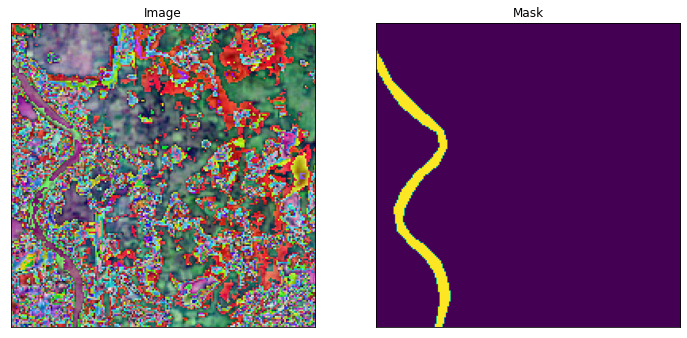

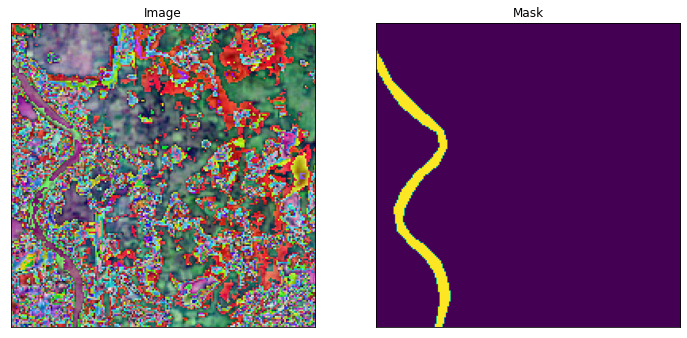

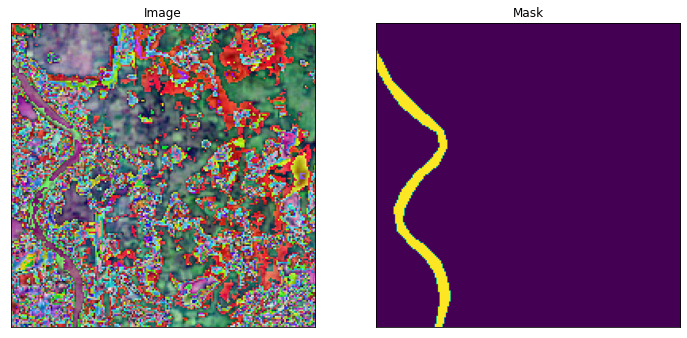

In [46]:
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['waterbody'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[20]
    visualize(image=image, mask=mask.squeeze(-1))

In [13]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

[1]
[1]


In [14]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [15]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    metrics=metrics,
    loss=loss,  
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    metrics=metrics, 
    loss=loss, 
    device=DEVICE,
    verbose=True,
)
#print(model)

In [16]:
# train model for 40 epochs

max_score = 0
epochnum=[]
trainiouscores=[]
traindiceloss=[]
trainfscore=[]
trainprecisions=[]
trainrecalls=[]
trainaccuracy=[]

validiouscores=[]
validdiceloss=[]
validfscore=[]
validprecisions=[]
validrecalls=[]
validaccuracy=[]

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    epochnum.append(i)
    
    ###Train Scores
    trainiouscores.append(train_logs['iou_score'])
    traindiceloss.append(train_logs['dice_loss'])
    trainfscore.append(train_logs['fscore'])
    trainprecisions.append(train_logs['precision'])
    trainrecalls.append(train_logs['recall'])
    trainaccuracy.append(train_logs['accuracy'])
    
    ###Valid Scores
    validiouscores.append(valid_logs['iou_score'])
    validdiceloss.append(valid_logs['dice_loss'])
    validfscore.append(valid_logs['fscore'])
    validprecisions.append(valid_logs['precision'])
    validrecalls.append(valid_logs['recall'])
    validaccuracy.append(valid_logs['accuracy'])
    
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['accuracy']:
        max_score = valid_logs['accuracy']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 20:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100%|█| 20/20 [00:04<00:00,  4.47it/s, dice_loss - 0.9129, iou_score - 0.0466, fscore - 0.08742, precision - 0.0
valid: 100%|█| 48/48 [00:01<00:00, 34.95it/s, dice_loss - 0.8898, iou_score - 0.05949, fscore - 0.1043, precision - 0.0
Model saved!

Epoch: 1
train: 100%|█| 20/20 [00:03<00:00,  6.43it/s, dice_loss - 0.9004, iou_score - 0.05731, fscore - 0.1058, precision - 0.0
valid: 100%|█| 48/48 [00:01<00:00, 33.97it/s, dice_loss - 0.8806, iou_score - 0.0785, fscore - 0.1351, precision - 0.07
Model saved!

Epoch: 2
train: 100%|█| 20/20 [00:03<00:00,  6.37it/s, dice_loss - 0.8928, iou_score - 0.07095, fscore - 0.1292, precision - 0.0
valid: 100%|█| 48/48 [00:01<00:00, 33.35it/s, dice_loss - 0.872, iou_score - 0.1326, fscore - 0.2177, precision - 0.135
Model saved!

Epoch: 3
train: 100%|█| 20/20 [00:03<00:00,  6.39it/s, dice_loss - 0.8749, iou_score - 0.1006, fscore - 0.1757, precision - 0.10
valid: 100%|█| 48/48 [00:01<00:00, 33.70it/s, dice_loss - 0.8717, iou_score - 0.1

In [17]:
print(trainaccuracy)

[0.26018778756260874, 0.4018625900149345, 0.5614535897970201, 0.6759972572326659, 0.7328837186098097]


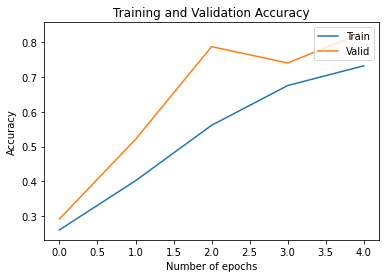

In [18]:
plt.plot(epochnum, trainaccuracy) 
plt.plot(epochnum,validaccuracy)
  
# naming the x axis 
plt.xlabel('Number of epochs') 
# naming the y axis 
plt.ylabel('Accuracy') 
  
# giving a title to my graph 
plt.title('Training and Validation Accuracy') 
plt.legend(["Train","Valid"],loc ="upper right")
plt.savefig("Training and Validation Accuracy.jpg")
# function to show the plot 
plt.show() 


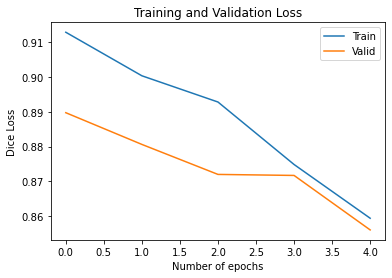

In [19]:
plt.plot(epochnum, traindiceloss) 
plt.plot(epochnum,validdiceloss)
# naming the x axis 
plt.xlabel('Number of epochs') 
# naming the y axis 
plt.ylabel('Dice Loss') 
  
# giving a title to my graph 
plt.title('Training and Validation Loss') 
plt.legend(["Train","Valid"],loc ="upper right")  

plt.savefig("Training and Validation Loss.jpg")
# function to show the plot 
plt.show() 

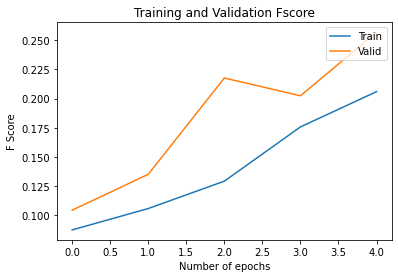

In [20]:
plt.plot(epochnum, trainfscore) 
plt.plot(epochnum,validfscore)  
# naming the x axis 
plt.xlabel('Number of epochs') 
# naming the y axis 
plt.ylabel('F Score') 
  
# giving a title to my graph 
plt.title('Training and Validation Fscore') 
plt.legend(["Train","Valid"],loc ="upper right")  
plt.savefig("Training and Validation Fscore.jpg")

# function to show the plot 
plt.show() 

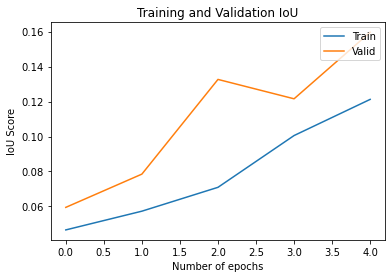

In [21]:
plt.plot(epochnum, trainiouscores) 
plt.plot(epochnum,validiouscores)  
# naming the x axis 
plt.xlabel('Number of epochs') 
# naming the y axis 
plt.ylabel('IoU Score') 
  
# giving a title to my graph 
plt.title('Training and Validation IoU') 
plt.legend(["Train","Valid"],loc ="upper right")  
plt.savefig("Training and Validation IoU.jpg")
# function to show the plot 
plt.show() 

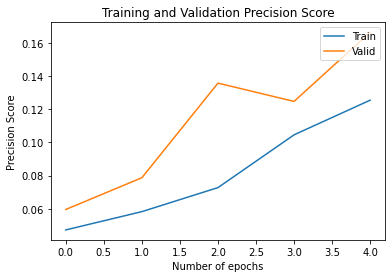

In [22]:
plt.plot(epochnum, trainprecisions) 
plt.plot(epochnum,validprecisions)  
# naming the x axis 
plt.xlabel('Number of epochs') 
# naming the y axis 
plt.ylabel('Precision Score') 
  
# giving a title to my graph 
plt.title('Training and Validation Precision Score') 
plt.legend(["Train","Valid"],loc ="upper right")  
plt.savefig("Training and Validation Precision Score.jpg")
# function to show the plot 
plt.show() 

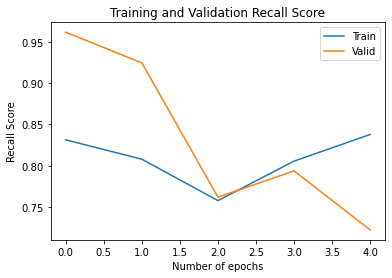

In [23]:
plt.plot(epochnum, trainrecalls) 
plt.plot(epochnum,validrecalls)  
# naming the x axis 
plt.xlabel('Number of epochs') 
# naming the y axis 
plt.ylabel('Recall Score') 
  
# giving a title to my graph 
plt.title('Training and Validation Recall Score') 
plt.legend(["Train","Valid"],loc ="upper right")  
plt.savefig("Training and Validation Recall Score.jpg")
# function to show the plot 
plt.show() 

In [24]:
best_model = torch.load('./best_model.pth')

In [25]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

[1]


In [26]:
# image,mask = test_dataset[61]
# visualize(
#     image = image,
#     ground_truthlabel = mask.squeeze()
# )

In [27]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model.cuda(),
    loss=loss.cuda(),
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|█| 30/30 [00:01<00:00, 25.04it/s, dice_loss - 0.8332, iou_score - 0.2074, fscore - 0.2984, precision - 0.22


In [28]:
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)


test_temp_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    #augmentation=get_validation_augmentation(), 
    #preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

[1]
[1]


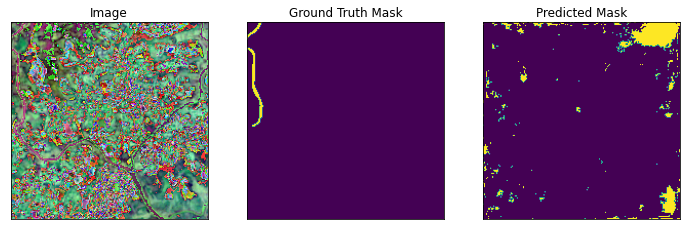

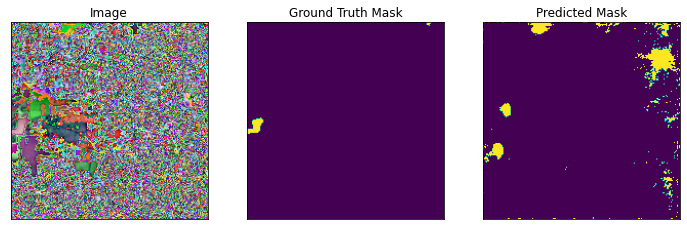

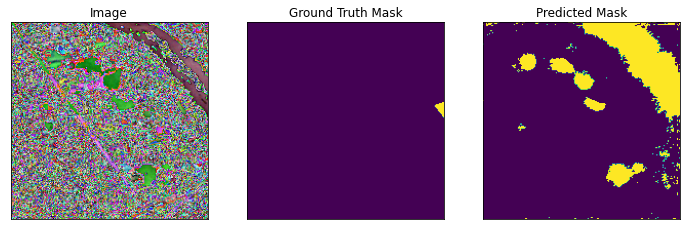

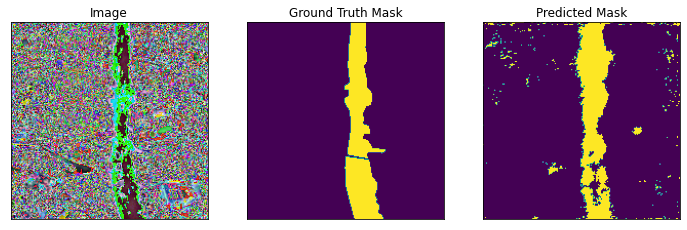

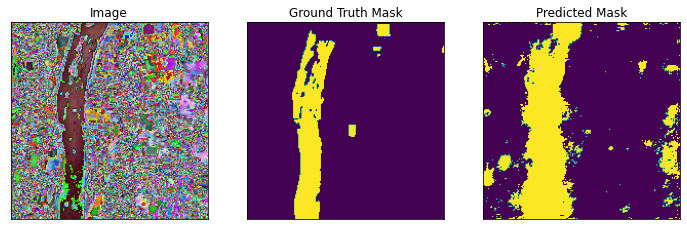

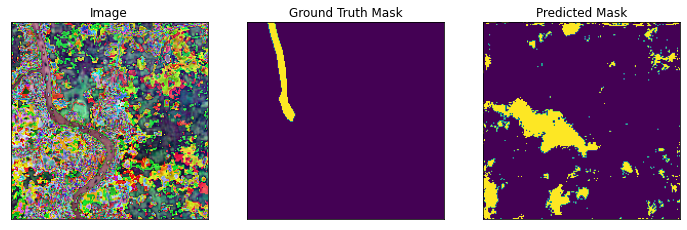

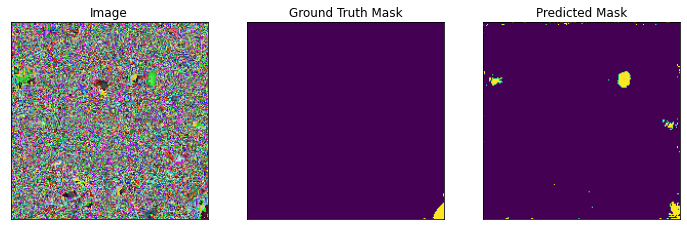

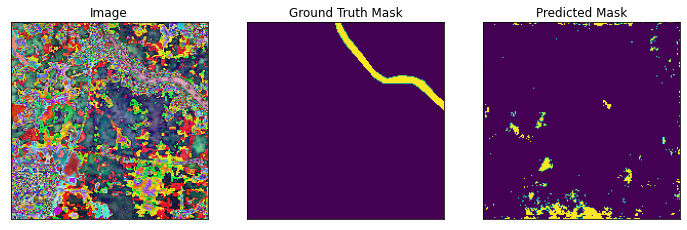

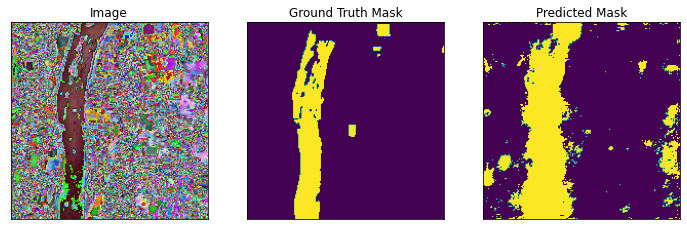

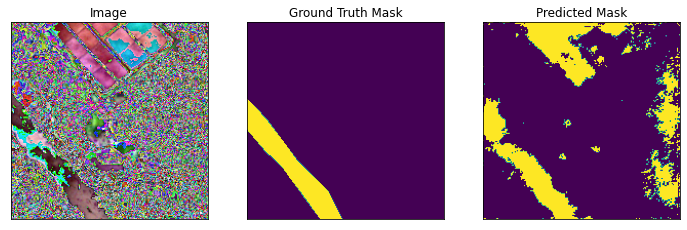

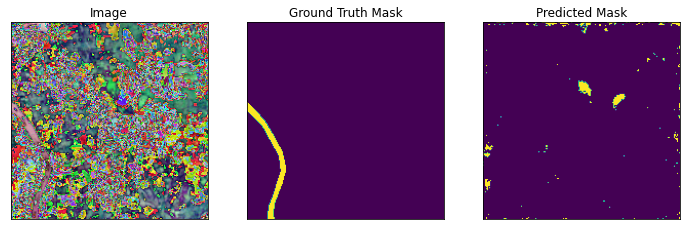

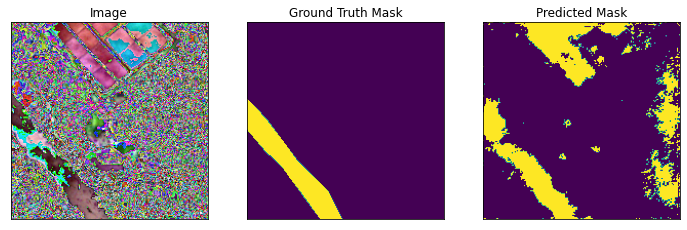

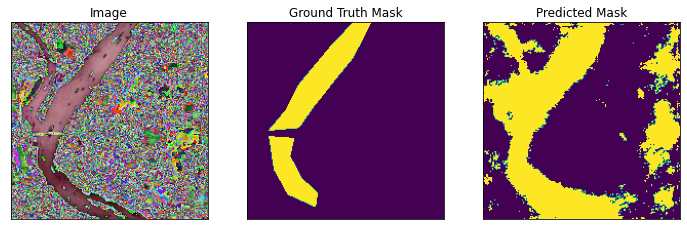

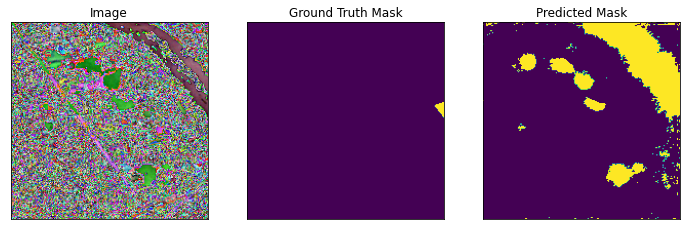

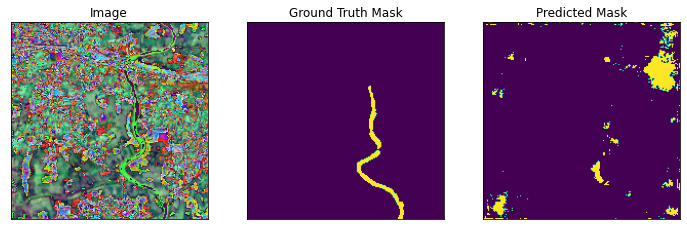

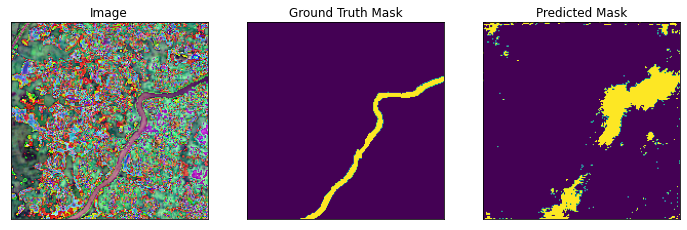

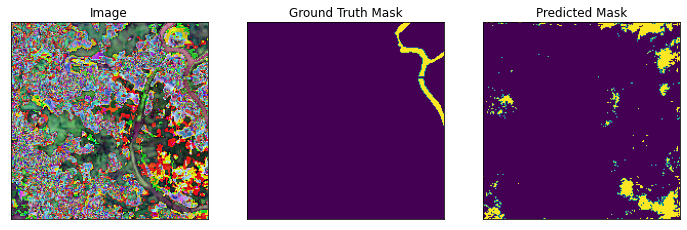

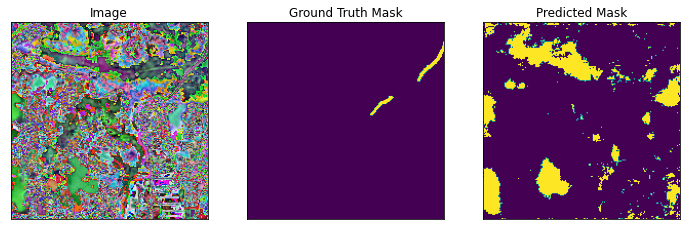

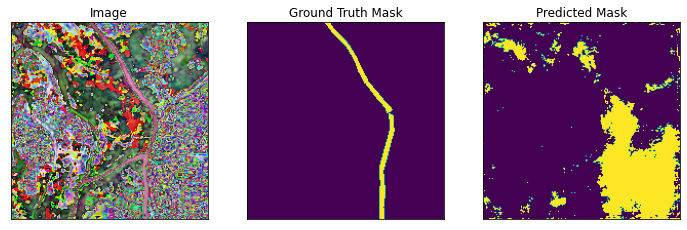

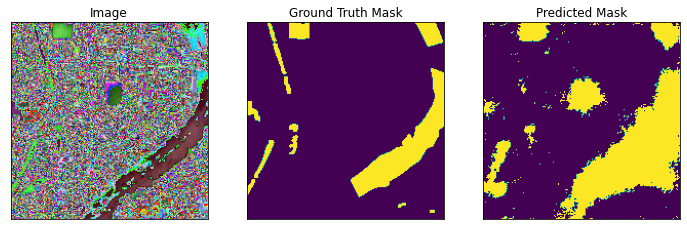

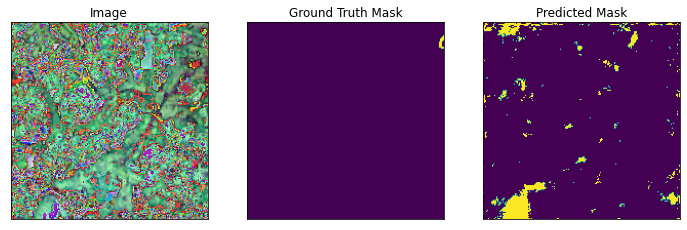

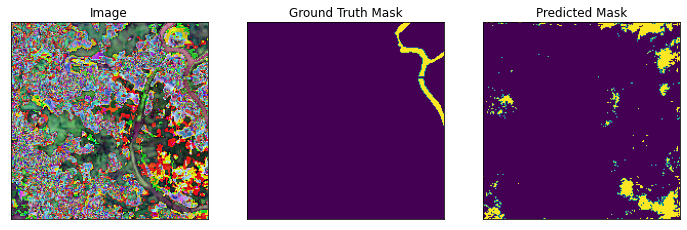

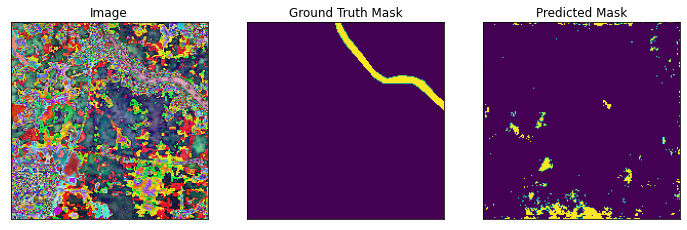

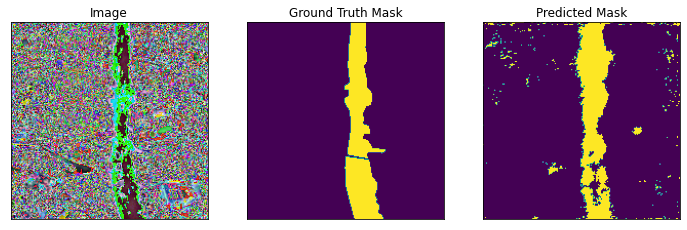

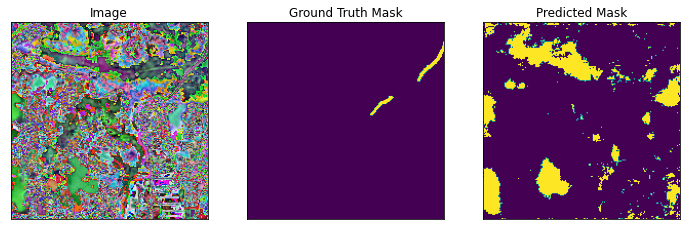

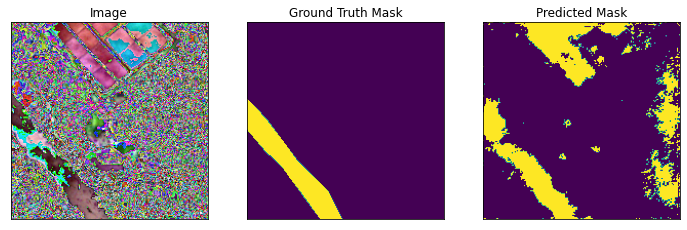

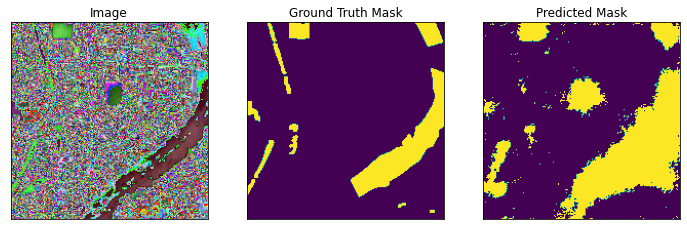

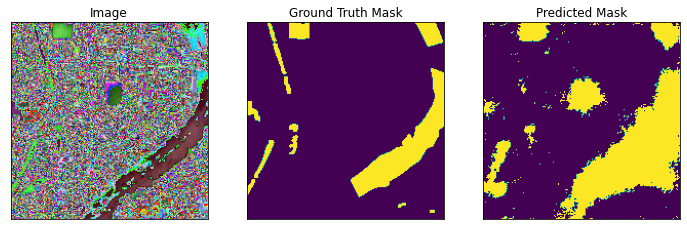

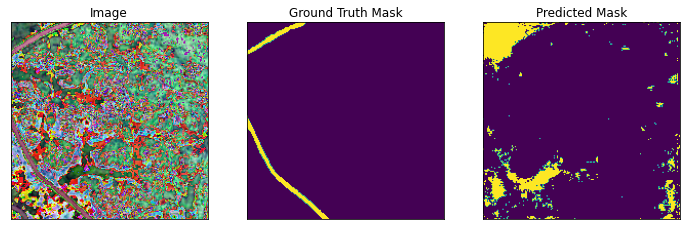

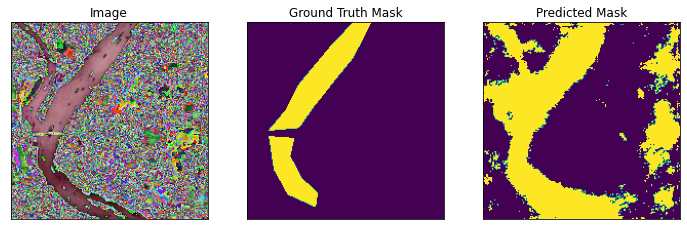

In [29]:
for i in range(30):
    n = np.random.choice(len(test_dataset))
    #n=23
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    tempimage, tempgt_mask = test_temp_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=tempgt_mask, 
        predicted_mask=pr_mask
    )

In [30]:

for i in range(len(epochnum)):
    print("Epoch ",i," trainacc ",trainaccuracy[i]," trainiou ",trainiouscores[i]," traindice ",traindiceloss[i]," trainfscore ",trainfscore[i]," trainprecisions ",trainprecisions[i]," trainrecall ",trainrecalls[i],"\n")

Epoch  0  trainacc  0.26018778756260874  trainiou  0.04659604718908668  traindice  0.9129396796226501  trainfscore  0.08742224471643567  trainprecisions  0.04719210686162113  trainrecall  0.8312796443700791 

Epoch  1  trainacc  0.4018625900149345  trainiou  0.057308460399508473  traindice  0.900400260090828  trainfscore  0.10576023403555153  trainprecisions  0.05822758013382554  trainrecall  0.8078822314739228 

Epoch  2  trainacc  0.5614535897970201  trainiou  0.07095057303085923  traindice  0.8928462028503419  trainfscore  0.12923283390700818  trainprecisions  0.07273738086223602  trainrecall  0.7578217118978501 

Epoch  3  trainacc  0.6759972572326659  trainiou  0.1005524594336748  traindice  0.8748530745506287  trainfscore  0.17574338838458062  trainprecisions  0.10460702273994683  trainrecall  0.8055918037891389 

Epoch  4  trainacc  0.7328837186098097  trainiou  0.1212309904396534  traindice  0.8593774288892746  trainfscore  0.2060020908713341  trainprecisions  0.125525172613561

In [31]:
trainiouscores=[]
traindiceloss=[]
trainfscore=[]
trainprecisions=[]
trainrecalls=[]
trainaccuracy=[]